# parPE steadystate example model

In [1]:
import amici
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Create sbml model from scratch
!./createSteadystateExampleSBML.py > model_steadystate_scaled.sbml

In [3]:
sbml_file = 'model_steadystate_scaled.sbml'
model_name = 'model_steadystate_scaled'
model_output_dir= 'model_steadystate_scaled'

In [4]:
# Show model info
import libsbml
SBMLreader = libsbml.SBMLReader()
sbml_doc = SBMLreader.readSBML(sbml_file)
sbml_model = sbml_doc.getModel()

print('Species: ', [s.getId() for s in sbml_model.getListOfSpecies()])

print('Parameters: ', [p.getId() for p in sbml_model.getListOfParameters()])

print('\nReactions:')
for reaction in sbml_model.getListOfReactions():
    reactants = ' + '.join(['%s %s'%(int(r.getStoichiometry()) if r.getStoichiometry() > 1 else '', r.getSpecies()) for r in reaction.getListOfReactants()])
    products  = ' + '.join(['%s %s'%(int(r.getStoichiometry()) if r.getStoichiometry() > 1 else '', r.getSpecies()) for r in reaction.getListOfProducts()])
    reversible = '<' if reaction.getReversible() else ''
    print('%3s: %10s %1s->%10s\t\t[%s]' % (reaction.getId(), 
                        reactants,
                        reversible,
                        products,
                        libsbml.formulaToL3String(reaction.getKineticLaw().getMath())))


Species:  ['x1', 'x2', 'x3']
Parameters:  ['p1', 'p2', 'p3', 'p4', 'p5', 'k0', 'observable_x1', 'observable_x2', 'observable_x3', 'scaling_x1', 'observable_x1_scaled', 'offset_x2', 'observable_x2_offsetted', 'observable_x1withsigma_sigma', 'observable_x1withsigma']

Reactions:
 r1:       2 x1  ->        x2		[p1 * x1^2]
 r2:   x1 +  x2  ->        x3		[p2 * x1 * x2]
 r3:         x2  ->      2 x1		[p3 * x2]
 r4:         x3  ->  x1 +  x2		[p4 * x3]
 r5:         x3  ->          		[k0 * x3]
 r6:             ->        x1		[p5]


## Generate model code

In [5]:
observables = []
fixed_parameters = ['k0']

def createModule(sbml_model_file, model_name, model_output_dir):
    """Create Python module from SBML model"""
    sbmlImporter = amici.SbmlImporter(sbml_model_file)
    sbml = sbmlImporter.sbml
    global observables
    observables = amici.assignmentRules2observables(sbml, filter=lambda variableId: 
                                                    variableId.startswith('observable_') and not variableId.endswith('_sigma'))
    
    print(observables)
    print(fixed_parameters)

    sbmlImporter.sbml2amici(model_name,
                            output_dir=model_output_dir,
                            observables=observables,
                            constantParameters=fixed_parameters,
                            sigmas={'observable_x1withsigma': 'observable_x1withsigma_sigma'})


createModule(sbml_file, model_name, model_output_dir)



{'observable_x1': 'x1', 'observable_x2': 'x2', 'observable_x3': 'x3', 'observable_x1_scaled': 'scaling_x1 * x1', 'observable_x2_offsetted': 'offset_x2 + x2', 'observable_x1withsigma': 'x1'}
['k0']


## Test simulation

In [6]:
def plotStateTrajectories(rdata):
    for ix in range(rdata['x'].shape[1]):
        plt.plot(rdata['t'], rdata['x'][:, ix], label='$x_%d$' % ix)
        plt.xlabel('$t$ (s)')
        plt.ylabel('$x_i(t)$ (mmol/ml)')
        plt.legend()
        plt.title('State trajectories')
    plt.show()
    
def plotObservableTrajectories(rdata):
    for iy in range(rdata['y'].shape[1]):
        plt.plot(rdata['t'], rdata['y'][:, iy], label='$y_%d$' % iy)
        plt.xlabel('$t$ (s)')
        plt.ylabel('$y_i(t)$ (AU)')
        plt.legend()
        plt.title('Observables')
    
    plt.show()


{'t': array([ 0.        ,  1.01694915,  2.03389831,  3.05084746,  4.06779661,
        5.08474576,  6.10169492,  7.11864407,  8.13559322,  9.15254237,
       10.16949153, 11.18644068, 12.20338983, 13.22033898, 14.23728814,
       15.25423729, 16.27118644, 17.28813559, 18.30508475, 19.3220339 ,
       20.33898305, 21.3559322 , 22.37288136, 23.38983051, 24.40677966,
       25.42372881, 26.44067797, 27.45762712, 28.47457627, 29.49152542,
       30.50847458, 31.52542373, 32.54237288, 33.55932203, 34.57627119,
       35.59322034, 36.61016949, 37.62711864, 38.6440678 , 39.66101695,
       40.6779661 , 41.69491525, 42.71186441, 43.72881356, 44.74576271,
       45.76271186, 46.77966102, 47.79661017, 48.81355932, 49.83050847,
       50.84745763, 51.86440678, 52.88135593, 53.89830508, 54.91525424,
       55.93220339, 56.94915254, 57.96610169, 58.98305085, 60.        ]), 'x': array([[0.1       , 0.4       , 0.7       ],
       [0.57995051, 0.73365809, 0.0951589 ],
       [0.55996496, 0.71470091, 0

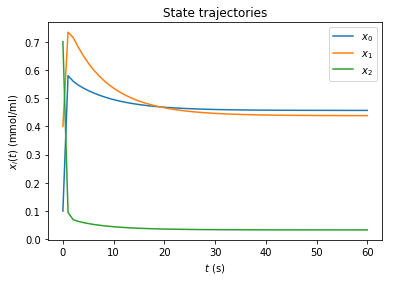

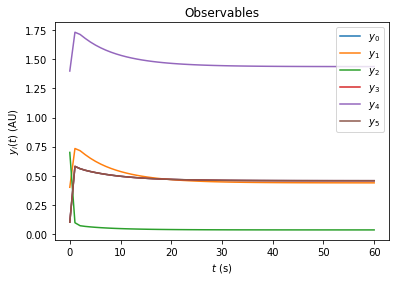

In [7]:
# load model
sys.path.insert(0, model_output_dir)
import model_steadystate_scaled as modelModule

model = modelModule.getModel()
model.setTimepoints(amici.DoubleVector(np.linspace(0, 60, 60))) 
solver = model.getSolver()
rdata = amici.runAmiciSimulation(model, solver)

print(rdata)

plotStateTrajectories(rdata)
plotObservableTrajectories(rdata)


## Create in silico experimental data for parameter estimation

In [8]:
expectedLlh = 0.0

def createData():
    # setup model & solver
    model = modelModule.getModel()
    model.setTimepoints(amici.DoubleVector(np.linspace(0, 60, 60)))
    print('True parameters: ', np.array(model.getParameters()))
    
    solver = model.getSolver()
    solver.setMaxSteps(10000)

    # generate conditon-vectors
    conditions = [np.array(model.getFixedParameters())]
    #conditions.append(conditions[0] * 1.5)
    
    conditionDf = createConditionDataframe(fixed_parameters, conditions)
    
    df = pd.DataFrame(data={
        'observable': [],
        'condition': [],
        'conditionRef': [],
        'scalingParameter': [],
        'time': [],
        'measurement': [],
        'sigma': []
    })

    global expectedLlh
    for icondition, condition in enumerate(conditions):      
        print('Condition %d: %s' % (icondition, condition))
        rdata = getReturnDataForCondition(model, solver, condition)
        
        print('\tllh: ', rdata['llh'])
        print('\tsllh', rdata['sllh'])

        expectedLlh += rdata['llh']
        
        conditionName = 'condition-%d' % icondition
        
        # Append data
        for iy, observableName in enumerate(observables.keys()):
            scalingParameter = [''] 
            sigma = [1.0]
            if observableName == 'observable_x1_scaled':
                scalingParameter = ['scaling_x1_%s' % conditionName]
            elif observableName == 'observable_x2_offsetted':
                scalingParameter = ['offset_x2_%s' % conditionName]
            elif observableName == 'observable_x1withsigma':
                scalingParameter = ['observable_x1withsigma_sigma_%s' % conditionName]
                sigma = [np.nan]
            
            df = df.append(pd.DataFrame(
            {'observable'      : [observableName] * model.nt(),
             'condition'       : [conditionName]  * model.nt(),
             'conditionRef'    : [conditionName]  * model.nt(),
             'scalingParameter': scalingParameter * model.nt(),
             'time'            : np.array(model.getTimepoints()),
             'measurement'     : rdata['y'][:, iy],
             'sigma'           : sigma * model.nt()
             }), ignore_index=True)
    print('Expected llh: ', expectedLlh)
            
    return df, conditionDf


def createConditionDataframe(fixed_parameters, conditions):
    """Create dataframe with fixed-parameters for each condition to simulate"""
    conditionDf = pd.DataFrame(index = fixed_parameters)
    conditionDf['ID'] = conditionDf.index
    for icondition, condition in enumerate(conditions):
        conditionDf['condition-%d' % icondition] = condition
    
    return conditionDf


def getReturnDataForCondition(model, solver, condition):
    # simulate without measurements
    edata = amici.ExpData(model.get())
    edata.fixedParameters = amici.DoubleVector(condition)
    edata.my = amici.DoubleVector(np.full(shape=model.nt() * model.nytrue, fill_value=np.nan))
    rdata = amici.runAmiciSimulation(model, solver, edata)        
    # fixedParametersPreequilibration = 
    
    # confirm gradient is 0 for real measurements and save expected llh
    edata.my = amici.DoubleVector(rdata['y'].flatten())
    sigmay = np.ones(shape=rdata['y'].shape)
    sigmay[:, 5] = np.nan
    edata.sigmay = amici.DoubleVector(sigmay.flatten())

    solver.setSensitivityMethod(amici.AMICI_SENSI_FSA)
    solver.setSensitivityOrder(amici.AMICI_SENSI_ORDER_FIRST)
    model.requireSensitivitiesForAllParameters()
    rdata = amici.runAmiciSimulation(model, solver, edata)
    
    return rdata

df, conditionDf = createData()

True parameters:  [1.  0.5 0.4 2.  0.1 1.  1.  1. ]
Condition 0: [1.]
	llh:  -330.8178719536814
	sllh [ 4.12539484e-08 -5.57037085e-07 -8.87095673e-08  9.63098775e-08
  2.39922870e-06  6.67619185e-08  3.42709685e-07 -6.00000000e+01]
Expected llh:  -330.8178719536814


In [9]:
df

,condition,conditionRef,measurement,observable,scalingParameter,sigma,time
0,condition-0,condition-0,0.100000,observable_x1,,1.0,0.000000
1,condition-0,condition-0,0.579951,observable_x1,,1.0,1.016949
2,condition-0,condition-0,0.559965,observable_x1,,1.0,2.033898
3,condition-0,condition-0,0.546285,observable_x1,,1.0,3.050847
4,condition-0,condition-0,0.535619,observable_x1,,1.0,4.067797
5,condition-0,condition-0,0.526365,observable_x1,,1.0,5.084746
6,condition-0,condition-0,0.518220,observable_x1,,1.0,6.101695
7,condition-0,condition-0,0.511038,observable_x1,,1.0,7.118644
8,condition-0,condition-0,0.504700,observable_x1,,1.0,8.135593
9,condition-0,condition-0,0.499107,observable_x1,,1.0,9.152542


In [10]:
conditionDf

,ID,condition-0
k0,k0,1.0


In [11]:
# write data frames to file
measurement_file = 'example_data.tsv'
fixed_parameter_file = 'example_data_fixed.tsv'
hdf5File = 'example_data.h5'

df.to_csv(measurement_file, sep='\t', index=False)
conditionDf.to_csv(fixed_parameter_file, sep='\t', index=False)

# convert to HDF5
import subprocess
out = subprocess.run(['%s/generateHDF5DataFileFromText.py' % os.path.join(os.getcwd(), '..', '..', '..', 'misc'),
    hdf5File,
    sbml_file,
    model_output_dir,
    measurement_file,
    fixed_parameter_file], stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
print(out.stdout.decode("utf-8"))
assert out.returncode==0


Cost shape (360, 7)
Changing t = Inf to t = 1e8.
Num conditions:  1
Num timepoints:  60 [0.0, 1.0169491525423728, 2.0338983050847457, 3.0508474576271185, 4.067796610169491, 5.084745762711863, 6.101694915254238, 7.118644067796611, 8.135593220338983, 9.152542372881355, 10.169491525423727, 11.186440677966099, 12.203389830508476, 13.220338983050848, 14.237288135593221, 15.254237288135593, 16.271186440677965, 17.28813559322034, 18.305084745762716, 19.322033898305087, 20.338983050847453, 21.355932203389827, 22.372881355932197, 23.38983050847457, 24.40677966101695, 25.423728813559322, 26.440677966101696, 27.457627118644066, 28.474576271186443, 29.49152542372881, 30.508474576271187, 31.525423728813557, 32.54237288135593, 33.559322033898304, 34.57627118644068, 35.593220338983045, 36.61016949152543, 37.627118644067785, 38.64406779661017, 39.66101694915254, 40.677966101694906, 41.69491525423729, 42.711864406779654, 43.72881355932204, 44.745762711864394, 45.76271186440679, 46.77966101694915, 47.79

In [12]:
# write true parameters as first starting point, an perturbed additional points
# two times the same point to check for reproducibility
true_parameters = np.array(model.getParameters())
import h5py
with h5py.File(hdf5File, 'r+') as f:
    for i in range(10):
        parameters = np.log10(true_parameters)
        parameters = parameters + np.random.normal(0.0, 0.0 + i * 0.01, true_parameters.shape)
        #print(parameters)
        f['/optimizationOptions/randomStarts'][:,2*i]   = parameters
        f['/optimizationOptions/randomStarts'][:,2*i+1] = parameters


In [13]:
# enable derivate checker
!../../../misc/optimizationOptions.py example_data.h5 -s ipopt/derivative_test first-order
!../../../misc/optimizationOptions.py example_data.h5 -s ipopt/derivative_test_print_all yes

!../../../misc/optimizationOptions.py example_data.h5 -s hierarchicalOptimization 0
!../../../misc/optimizationOptions.py example_data.h5


                               optimizer            0
                       retryOptimization            1
                               numStarts            1
                hierarchicalOptimization            0
                ceres/max_num_iterations          100
                          ipopt/max_iter          100
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                               ipopt/tol        1e-09
                   ipopt/acceptable_iter            1
                    ipopt/acceptable_tol        1e+20
         ipopt/acceptable_obj_change_tol        1e-18
   ipopt/watchdog_shortened_iter_trigger            0
                   ipopt/derivative_test b'first-order'
         ipopt/derivative_test_print_all       b'yes'
                          toms611/mxfcal  100000000.0


## Optimize

In [14]:
!pwd
!(cd ../../../build && exec make -j12)
!../../../build/amici/examples/steadystate/example_steadystate_multi  -o deleteme/ example_data.h5


/home/dweindl/src/parPE/amici/examples/steadystate
-- Found Git: /usr/bin/git (found version "2.14.1") 
Scanning dependencies of target model_steadystate_scaled
[  2%] Built target toms611
[  4%] Built target fsqp
[  9%] Built target parpecommon
-- Building version parPE-v0.1.5-31-gdcca1-dirty
[  9%] Built target get_version
[ 10%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_JB.cpp.o
[ 11%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_JDiag.cpp.o
[ 11%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_J.cpp.o
[ 11%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_Jy.cpp.o
[ 12%] Building CXX object amici/examples/steadystate/model

[ 98%] Built target example_steadystate_multi
[ 98%] Built target example_steadystate_multi_simulator
[ 98%] Linking CXX executable test_steadystate
CMakeFiles/test_steadystate.dir/__/__/__/common/src/testingMisc.cpp.o: In function `parpe::captureStreamToString[abi:cxx11](std::function<void ()>, _IO_FILE*, int)':
/home/dweindl/src/parPE/common/src/testingMisc.cpp:70: warning: the use of `tmpnam' is dangerous, better use `mkstemp'
[100%] Built target test_steadystate
[2018-06-10 15:52:11] [DBG] [-1/] MPI not initialized.
[2018-06-10 15:52:11] [DBG] [-1/] Seeding RNG with 1528638731
[2018-06-10 15:52:11] [DBG] [-1/] Writing results to deleteme/_rank-0001.h5.
[2018-06-10 15:52:11] [DBG] [-1/] Starting runParallelMultiStartOptimization with 1 starts sequentially
[2018-06-10 15:52:11] [INF] [-1/] Reading random initial theta 0 from /optimizationOptions/randomStarts
[2018-06-10 15:52:11] [DBG] [-1/] Set optimization option acceptable_iter to 1.
[2018-06-10 15:52:11] [DBG] [-1/] Set optimizat

[2018-06-10 15:52:11] [DBG] [-1/] Result for 0.0.0.0 (0): -51.279 (0) (0.0448s)
[2018-06-10 15:52:11] [INF] [-1/] iter: 3 cost: 51.279 time_iter: 0.0759022s time_optim: 0.501689s
   3  5.1278975e+01 0.00e+00 3.57e+02   0.9 4.45e+00    -  1.00e+00 9.17e-02f  4
[2018-06-10 15:52:11] [DBG] [-1/] Result for 0.0.0.0 (0): -1.11114e+09 (0) (0.0018s)
[2018-06-10 15:52:11] [DBG] [-1/] Result for 0.0.0.0 (0): -1.11114e+09 (0) (0.0020s)
[2018-06-10 15:52:11] [DBG] [-1/] Result for 0.0.0.0 (0): -1.11114e+09 (0) (0.0020s)
[2018-06-10 15:52:11] [DBG] [-1/] Result for 0.0.0.0 (0): -1.11114e+09 (0) (0.0018s)
[2018-06-10 15:52:11] [DBG] [-1/] Result for 0.0.0.0 (0): -1.11114e+09 (0) (0.0018s)
[2018-06-10 15:52:11] [DBG] [-1/] Result for 0.0.0.0 (0): -240970 (0) (0.0018s)
[2018-06-10 15:52:11] [DBG] [-1/] Result for 0.0.0.0 (0): -1405.89 (0) (0.0022s)
[2018-06-10 15:52:11] [DBG] [-1/] Result for 0.0.0.0 (0): -40.3336 (0) (0.0017s)
[2018-06-10 15:52:11] [DBG] [-1/] Result for 0.0.0.0 (0): -40.3336 (0) (0

[2018-06-10 15:52:12] [DBG] [-1/] Result for 0.0.0.0 (0): 79.3035 (0) (0.0464s)
[2018-06-10 15:52:12] [INF] [-1/] iter: 12 cost: -79.3035 time_iter: 0.0837852s time_optim: 1.16927s
  12 -7.9303519e+01 0.00e+00 4.97e+03  -0.9 2.91e+00    -  1.00e+00 4.63e-02f  5
[2018-06-10 15:52:12] [DBG] [-1/] Result for 0.0.0.0 (0): -5.67521e+06 (0) (0.0021s)
[2018-06-10 15:52:12] [DBG] [-1/] Result for 0.0.0.0 (0): -5.67521e+06 (0) (0.0021s)
[2018-06-10 15:52:12] [DBG] [-1/] Result for 0.0.0.0 (0): -5.67521e+06 (0) (0.0023s)
[2018-06-10 15:52:12] [DBG] [-1/] Result for 0.0.0.0 (0): -5.67521e+06 (0) (0.0021s)
[2018-06-10 15:52:12] [DBG] [-1/] Result for 0.0.0.0 (0): -5.67521e+06 (0) (0.0024s)
[2018-06-10 15:52:12] [DBG] [-1/] Result for 0.0.0.0 (0): -708666 (0) (0.0016s)
[2018-06-10 15:52:12] [DBG] [-1/] Result for 0.0.0.0 (0): -60811 (0) (0.0015s)
[2018-06-10 15:52:12] [DBG] [-1/] Result for 0.0.0.0 (0): -4191.1 (0) (0.0014s)
[2018-06-10 15:52:12] [DBG] [-1/] Result for 0.0.0.0 (0): -223.178 (0) (0.

[2018-06-10 15:52:12] [DBG] [-1/] Result for 0.0.0.0 (0): -1421.75 (0) (0.0019s)
[2018-06-10 15:52:12] [DBG] [-1/] Result for 0.0.0.0 (0): -151.762 (0) (0.0021s)
[2018-06-10 15:52:12] [DBG] [-1/] Result for 0.0.0.0 (0): 81.1755 (0) (0.0021s)
[2018-06-10 15:52:12] [DBG] [-1/] Result for 0.0.0.0 (0): 144.736 (0) (0.0020s)
[2018-06-10 15:52:12] [DBG] [-1/] Result for 0.0.0.0 (0): 158.171 (0) (0.0019s)
[2018-06-10 15:52:13] [DBG] [-1/] Result for 0.0.0.0 (0): 158.171 (0) (0.0466s)
[2018-06-10 15:52:13] [INF] [-1/] iter: 20 cost: -158.171 time_iter: 0.0968671s time_optim: 1.88451s
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -1.5817052e+02 0.00e+00 1.04e+05   1.0 4.80e+00    -  1.00e+00 5.26e-03f  8
[2018-06-10 15:52:13] [DBG] [-1/] Result for 0.0.0.0 (0): -29004.3 (0) (0.0017s)
[2018-06-10 15:52:13] [DBG] [-1/] Result for 0.0.0.0 (0): -29004.3 (0) (0.0015s)
[2018-06-10 15:52:13] [DBG] [-1/] Result for 0.0.0.0 (0): -29004.3 (0) (0.0016s)
[2018-06-10 

[2018-06-10 15:52:13] [DBG] [-1/] Result for 0.0.0.0 (0): 84.3245 (0) (0.0015s)
[2018-06-10 15:52:13] [DBG] [-1/] Result for 0.0.0.0 (0): 84.3245 (0) (0.0020s)
[2018-06-10 15:52:13] [DBG] [-1/] Result for 0.0.0.0 (0): 84.8899 (0) (0.0020s)
[2018-06-10 15:52:13] [DBG] [-1/] Result for 0.0.0.0 (0): 84.8899 (0) (0.0478s)
[2018-06-10 15:52:13] [INF] [-1/] iter: 32 cost: -84.8899 time_iter: 0.0748288s time_optim: 2.69249s
  32 -8.4889894e+01 0.00e+00 5.74e+02   1.9 2.78e-03    -  1.00e+00 5.00e-01f  2
[2018-06-10 15:52:13] [DBG] [-1/] Result for 0.0.0.0 (0): 85.042 (0) (0.0015s)
[2018-06-10 15:52:13] [DBG] [-1/] Result for 0.0.0.0 (0): 85.042 (0) (0.0436s)
[2018-06-10 15:52:13] [INF] [-1/] iter: 33 cost: -85.042 time_iter: 0.054447s time_optim: 2.74693s
  33 -8.5041997e+01 0.00e+00 3.19e+02   1.2 6.30e-04    -  1.00e+00 1.00e+00f  1
[2018-06-10 15:52:13] [DBG] [-1/] Result for 0.0.0.0 (0): 84.8667 (0) (0.0015s)
[2018-06-10 15:52:13] [DBG] [-1/] Result for 0.0.0.0 (0): 84.8667 (0) (0.0016s)


[2018-06-10 15:52:14] [DBG] [-1/] Result for 0.0.0.0 (0): 154.74 (0) (0.0483s)
[2018-06-10 15:52:14] [INF] [-1/] iter: 41 cost: -154.74 time_iter: 0.0947967s time_optim: 3.34126s
  41 -1.5474009e+02 0.00e+00 2.14e+04   1.2 3.98e+01    -  1.14e-01 1.41e-04f  9
[2018-06-10 15:52:14] [DBG] [-1/] Result for 0.0.0.0 (0): -52907.9 (0) (0.0018s)
[2018-06-10 15:52:14] [DBG] [-1/] Result for 0.0.0.0 (0): -52907.9 (0) (0.0016s)
[2018-06-10 15:52:14] [DBG] [-1/] Result for 0.0.0.0 (0): -52907.9 (0) (0.0015s)
[2018-06-10 15:52:14] [DBG] [-1/] Result for 0.0.0.0 (0): -52907.9 (0) (0.0018s)
[2018-06-10 15:52:14] [DBG] [-1/] Result for 0.0.0.0 (0): -52907.9 (0) (0.0018s)
[2018-06-10 15:52:14] [DBG] [-1/] Result for 0.0.0.0 (0): -13449.1 (0) (0.0015s)
[2018-06-10 15:52:14] [DBG] [-1/] Result for 0.0.0.0 (0): -1709.79 (0) (0.0015s)
[2018-06-10 15:52:14] [DBG] [-1/] Result for 0.0.0.0 (0): -37.4699 (0) (0.0015s)
[2018-06-10 15:52:14] [DBG] [-1/] Result for 0.0.0.0 (0): 146.114 (0) (0.0015s)
[2018-06-10 

[2018-06-10 15:52:15] [DBG] [-1/] Result for 0.0.0.0 (0): 125.077 (0) (0.0419s)
[2018-06-10 15:52:15] [INF] [-1/] iter: 49 cost: -125.077 time_iter: 0.0739665s time_optim: 4.04843s
  49 -1.2507691e+02 0.00e+00 2.47e+04   2.1 3.93e+00    -  1.00e+00 1.25e-01f  4
[2018-06-10 15:52:15] [DBG] [-1/] Result for 0.0.0.0 (0): -2112.32 (0) (0.0015s)
[2018-06-10 15:52:15] [DBG] [-1/] Result for 0.0.0.0 (0): -2112.33 (0) (0.0015s)
[2018-06-10 15:52:15] [DBG] [-1/] Result for 0.0.0.0 (0): -2112.33 (0) (0.0015s)
[2018-06-10 15:52:15] [DBG] [-1/] Result for 0.0.0.0 (0): -2112.33 (0) (0.0015s)
[2018-06-10 15:52:15] [DBG] [-1/] Result for 0.0.0.0 (0): -2112.33 (0) (0.0017s)
[2018-06-10 15:52:15] [DBG] [-1/] Result for 0.0.0.0 (0): 117.725 (0) (0.0019s)
[2018-06-10 15:52:15] [DBG] [-1/] Result for 0.0.0.0 (0): 147.621 (0) (0.0015s)
[2018-06-10 15:52:15] [DBG] [-1/] Result for 0.0.0.0 (0): 147.621 (0) (0.0444s)
[2018-06-10 15:52:15] [INF] [-1/] iter: 50 cost: -147.621 time_iter: 0.0727113s time_optim: 4

[2018-06-10 15:52:15] [DBG] [-1/] Result for 0.0.0.0 (0): 239.861 (0) (0.0430s)
[2018-06-10 15:52:15] [INF] [-1/] iter: 57 cost: -239.861 time_iter: 0.0795896s time_optim: 4.65697s
  57 -2.3986117e+02 0.00e+00 3.89e+04  -0.5 3.60e+00    -  1.00e+00 3.12e-02f  6
[2018-06-10 15:52:15] [DBG] [-1/] Result for 0.0.0.0 (0): -2.66036e+08 (0) (0.0021s)
[2018-06-10 15:52:15] [DBG] [-1/] Result for 0.0.0.0 (0): -2.66036e+08 (0) (0.0020s)
[2018-06-10 15:52:15] [DBG] [-1/] Result for 0.0.0.0 (0): -2.66036e+08 (0) (0.0021s)
[2018-06-10 15:52:15] [DBG] [-1/] Result for 0.0.0.0 (0): -2.66036e+08 (0) (0.0021s)
[2018-06-10 15:52:15] [DBG] [-1/] Result for 0.0.0.0 (0): -2.66036e+08 (0) (0.0026s)
[2018-06-10 15:52:15] [DBG] [-1/] Result for 0.0.0.0 (0): -3.67662e+07 (0) (0.0018s)
[2018-06-10 15:52:15] [DBG] [-1/] Result for 0.0.0.0 (0): -4.4048e+06 (0) (0.0016s)
[2018-06-10 15:52:15] [DBG] [-1/] Result for 0.0.0.0 (0): -435259 (0) (0.0016s)
[2018-06-10 15:52:15] [DBG] [-1/] Result for 0.0.0.0 (0): -37963

[2018-06-10 15:52:16] [DBG] [-1/] Result for 0.0.0.0 (0): 271.88 (0) (0.0437s)
[2018-06-10 15:52:16] [INF] [-1/] iter: 64 cost: -271.88 time_iter: 0.078178s time_optim: 5.25418s
  64 -2.7188008e+02 0.00e+00 2.47e+04   1.4 9.24e+00    -  1.00e+00 2.16e-02f  5
[2018-06-10 15:52:16] [DBG] [-1/] Result for 0.0.0.0 (0): -4.52559e+07 (0) (0.0020s)
[2018-06-10 15:52:16] [DBG] [-1/] Result for 0.0.0.0 (0): -4.52559e+07 (0) (0.0020s)
[2018-06-10 15:52:16] [DBG] [-1/] Result for 0.0.0.0 (0): -4.52559e+07 (0) (0.0015s)
[2018-06-10 15:52:16] [DBG] [-1/] Result for 0.0.0.0 (0): -4.52559e+07 (0) (0.0016s)
[2018-06-10 15:52:16] [DBG] [-1/] Result for 0.0.0.0 (0): -4.52559e+07 (0) (0.0016s)
[2018-06-10 15:52:16] [DBG] [-1/] Result for 0.0.0.0 (0): -1.38826e+06 (0) (0.0015s)
[2018-06-10 15:52:16] [DBG] [-1/] Result for 0.0.0.0 (0): -63934.7 (0) (0.0015s)
[2018-06-10 15:52:16] [DBG] [-1/] Result for 0.0.0.0 (0): -3405.43 (0) (0.0015s)
[2018-06-10 15:52:16] [DBG] [-1/] Result for 0.0.0.0 (0): 16.9202 (0)

[2018-06-10 15:52:17] [DBG] [-1/] Result for 0.0.0.0 (0): 290.16 (0) (0.0448s)
[2018-06-10 15:52:17] [INF] [-1/] iter: 71 cost: -290.16 time_iter: 0.0821143s time_optim: 5.8987s
  71 -2.9015991e+02 0.00e+00 1.55e+04   1.5 3.18e+00    -  1.00e+00 1.56e-02f  7
[2018-06-10 15:52:17] [DBG] [-1/] Result for 0.0.0.0 (0): -8.96523e+07 (0) (0.0018s)
[2018-06-10 15:52:17] [DBG] [-1/] Result for 0.0.0.0 (0): -8.96523e+07 (0) (0.0017s)
[2018-06-10 15:52:17] [DBG] [-1/] Result for 0.0.0.0 (0): -8.96523e+07 (0) (0.0019s)
[2018-06-10 15:52:17] [DBG] [-1/] Result for 0.0.0.0 (0): -8.96523e+07 (0) (0.0017s)
[2018-06-10 15:52:17] [DBG] [-1/] Result for 0.0.0.0 (0): -8.96523e+07 (0) (0.0017s)
[2018-06-10 15:52:17] [DBG] [-1/] Result for 0.0.0.0 (0): -5.51696e+06 (0) (0.0016s)
[2018-06-10 15:52:17] [DBG] [-1/] Result for 0.0.0.0 (0): -374297 (0) (0.0017s)
[2018-06-10 15:52:17] [DBG] [-1/] Result for 0.0.0.0 (0): -23167.5 (0) (0.0015s)
[2018-06-10 15:52:17] [DBG] [-1/] Result for 0.0.0.0 (0): -1094.18 (0)

[2018-06-10 15:52:17] [DBG] [-1/] Result for 0.0.0.0 (0): -553292 (0) (0.0019s)
[2018-06-10 15:52:17] [DBG] [-1/] Result for 0.0.0.0 (0): -27895 (0) (0.0021s)
[2018-06-10 15:52:17] [DBG] [-1/] Result for 0.0.0.0 (0): -1613.69 (0) (0.0020s)
[2018-06-10 15:52:17] [DBG] [-1/] Result for 0.0.0.0 (0): 30.3262 (0) (0.0019s)
[2018-06-10 15:52:17] [DBG] [-1/] Result for 0.0.0.0 (0): 154.666 (0) (0.0016s)
[2018-06-10 15:52:17] [DBG] [-1/] Result for 0.0.0.0 (0): 166.515 (0) (0.0020s)
[2018-06-10 15:52:17] [DBG] [-1/] Result for 0.0.0.0 (0): 168.076 (0) (0.0017s)
[2018-06-10 15:52:17] [DBG] [-1/] Result for 0.0.0.0 (0): 168.076 (0) (0.0570s)
[2018-06-10 15:52:17] [INF] [-1/] iter: 79 cost: -168.076 time_iter: 0.099505s time_optim: 6.5463s
  79 -1.6807630e+02 0.00e+00 3.91e+03   2.2 6.20e-01    -  1.00e+00 1.56e-02f  7
[2018-06-10 15:52:17] [DBG] [-1/] Result for 0.0.0.0 (0): 156.19 (0) (0.0015s)
[2018-06-10 15:52:17] [DBG] [-1/] Result for 0.0.0.0 (0): 156.19 (0) (0.0015s)
[2018-06-10 15:52:17] 

[2018-06-10 15:52:18] [DBG] [-1/] Result for 0.0.0.0 (0): 186.314 (0) (0.0443s)
[2018-06-10 15:52:18] [INF] [-1/] iter: 87 cost: -186.314 time_iter: 0.0883075s time_optim: 7.16292s
  87 -1.8631383e+02 0.00e+00 1.95e+04   1.5 5.27e+01    -  9.03e-01 1.49e-03f  7
[2018-06-10 15:52:18] [DBG] [-1/] Result for 0.0.0.0 (0): 128.328 (0) (0.0015s)
[2018-06-10 15:52:18] [DBG] [-1/] Result for 0.0.0.0 (0): 128.328 (0) (0.0015s)
[2018-06-10 15:52:18] [DBG] [-1/] Result for 0.0.0.0 (0): 128.328 (0) (0.0015s)
[2018-06-10 15:52:18] [DBG] [-1/] Result for 0.0.0.0 (0): 128.328 (0) (0.0021s)
[2018-06-10 15:52:18] [DBG] [-1/] Result for 0.0.0.0 (0): 128.328 (0) (0.0015s)
[2018-06-10 15:52:18] [DBG] [-1/] Result for 0.0.0.0 (0): 179.106 (0) (0.0016s)
[2018-06-10 15:52:18] [DBG] [-1/] Result for 0.0.0.0 (0): 189.593 (0) (0.0015s)
[2018-06-10 15:52:18] [DBG] [-1/] Result for 0.0.0.0 (0): 189.593 (0) (0.0452s)
[2018-06-10 15:52:18] [INF] [-1/] iter: 88 cost: -189.593 time_iter: 0.0733786s time_optim: 7.2363

[2018-06-10 15:52:18] [DBG] [-1/] Result for 0.0.0.0 (0): 209.085 (0) (0.0425s)
[2018-06-10 15:52:18] [INF] [-1/] iter: 94 cost: -209.085 time_iter: 0.0827721s time_optim: 7.7409s
  94 -2.0908535e+02 0.00e+00 1.52e+04   1.5 4.84e+00    -  1.00e+00 6.02e-03f  7
[2018-06-10 15:52:18] [DBG] [-1/] Result for 0.0.0.0 (0): -4.20037e+08 (0) (0.0016s)
[2018-06-10 15:52:18] [DBG] [-1/] Result for 0.0.0.0 (0): -4.20037e+08 (0) (0.0017s)
[2018-06-10 15:52:18] [DBG] [-1/] Result for 0.0.0.0 (0): -4.20037e+08 (0) (0.0016s)
[2018-06-10 15:52:18] [DBG] [-1/] Result for 0.0.0.0 (0): -4.20037e+08 (0) (0.0016s)
[2018-06-10 15:52:18] [DBG] [-1/] Result for 0.0.0.0 (0): -4.20037e+08 (0) (0.0015s)
[2018-06-10 15:52:18] [DBG] [-1/] Result for 0.0.0.0 (0): -3.70564e+06 (0) (0.0015s)
[2018-06-10 15:52:18] [DBG] [-1/] Result for 0.0.0.0 (0): -97613.4 (0) (0.0016s)
[2018-06-10 15:52:18] [DBG] [-1/] Result for 0.0.0.0 (0): -4618.4 (0) (0.0015s)
[2018-06-10 15:52:18] [DBG] [-1/] Result for 0.0.0.0 (0): -187.22 (0

## Compare results

In [15]:
with h5py.File('deleteme/_rank-0001.h5', 'r') as f:
    final_parameters = f['/multistarts/0/finalParameters'][:]
    exit_status = f['/multistarts/0/exitStatus'][:]
    final_cost = f['/multistarts/0/finalCost'][:]
final_parameters = np.power(10, final_parameters)

print("#  __Exp___ __Act___ __Err____")
for i in range(len(true_parameters)):
    print('%d: %6f %6f %6f' % (i, true_parameters[i], final_parameters[i], final_parameters[i]-true_parameters[i]))
print('Status: %d' % exit_status)
print('Cost: %f (expected: %f)' % (final_cost, -expectedLlh))

#  __Exp___ __Act___ __Err____
0: 1.000000 1.024872 0.024872
1: 0.500000 0.499366 -0.000634
2: 0.400000 0.410985 0.010985
3: 2.000000 1.995014 -0.004986
4: 0.100000 0.100217 0.000217
5: 1.000000 0.183934 -0.816066
6: 1.000000 0.873524 -0.126476
7: 1.000000 0.000077 -0.999923
Status: 1
Cost: -231.217518 (expected: 330.817872)


In [16]:
!PARPE_NO_DEBUG=1 ../../../build/amici/examples/steadystate/example_steadystate_multi -t gradient_check -o deleteme/ example_data.h5


[2018-06-10 15:52:19] [INF] [-1/]     0 g:      125.675  fd_c:      125.675  Δ/fd_c: -1.172378e-07
[2018-06-10 15:52:19] [WRN] [-1/]     1 g:      4.85258  fd_c:      4.85252  Δ/fd_c: 1.334026e-05
[2018-06-10 15:52:19] [WRN] [-1/]     2 g:     -6.62188  fd_c:     -6.62166  Δ/fd_c: 3.458968e-05
[2018-06-10 15:52:19] [INF] [-1/]     3 g:     -313.434  fd_c:     -313.433  Δ/fd_c: 3.708142e-07
[2018-06-10 15:52:19] [INF] [-1/]     4 g:      -634.71  fd_c:      -634.71  Δ/fd_c: 4.357587e-08
[2018-06-10 15:52:19] [ERR] [-1/]     5 g: -0.000213772  fd_c: -0.000295586  Δ/fd_c: -2.864762e-01
[2018-06-10 15:52:19] [INF] [-1/]     6 g:      106.511  fd_c:      106.511  Δ/fd_c: 1.050083e-07
[2018-06-10 15:52:19] [INF] [-1/]     7 g:     -8388.36  fd_c:     -8388.36  Δ/fd_c: 5.705518e-09
[2018-06-10 15:52:19] [INF] [-1/] Walltime on master: 0.129242s, CPU time of all processes: 0.310180s


## Hierarchical optimization

In [17]:
!../../../misc/optimizationOptions.py example_data.h5 -s hierarchicalOptimization 1
!../../../misc/optimizationOptions.py example_data.h5


                               optimizer            0
                       retryOptimization            1
                               numStarts            1
                hierarchicalOptimization            1
                ceres/max_num_iterations          100
                          ipopt/max_iter          100
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                               ipopt/tol        1e-09
                   ipopt/acceptable_iter            1
                    ipopt/acceptable_tol        1e+20
         ipopt/acceptable_obj_change_tol        1e-18
   ipopt/watchdog_shortened_iter_trigger            0
                   ipopt/derivative_test b'first-order'
         ipopt/derivative_test_print_all       b'yes'
                          toms611/mxfcal  100000000.0


In [18]:
# gradient check 
!PARPE_NO_DEBUG=1 ../../../build/amici/examples/steadystate/example_steadystate_multi -t gradient_check -o deleteme/ example_data.h5


HierachicalOptimizationWrapper parameters: 5 total, 8 numerical, 1 proportionality, 1 offset, 1 sigma
[2018-06-10 15:52:20] [INF] [-1/]     0 g:      4.14367  fd_c:       4.1437  Δ/fd_c: -7.318209e-06
[2018-06-10 15:52:20] [WRN] [-1/]     1 g:  0.000442853  fd_c:  0.000466116  Δ/fd_c: -4.885939e-02
[2018-06-10 15:52:20] [INF] [-1/]     2 g:     -3.50904  fd_c:     -3.50906  Δ/fd_c: -4.870395e-06
[2018-06-10 15:52:20] [WRN] [-1/]     3 g:    -0.012322  fd_c:   -0.0122981  Δ/fd_c: 1.948513e-03
[2018-06-10 15:52:20] [WRN] [-1/]     4 g:    -0.394789  fd_c:      -0.3948  Δ/fd_c: -2.853091e-05
[2018-06-10 15:52:20] [INF] [-1/] Walltime on master: 0.150308s, CPU time of all processes: 0.363289s


In [19]:
# optimization
!../../../build/amici/examples/steadystate/example_steadystate_multi  -o deleteme/ example_data.h5


[2018-06-10 15:52:21] [DBG] [-1/] MPI not initialized.
[2018-06-10 15:52:21] [DBG] [-1/] Seeding RNG with 1528638741
HierachicalOptimizationWrapper parameters: 5 total, 8 numerical, 1 proportionality, 1 offset, 1 sigma
[2018-06-10 15:52:21] [DBG] [-1/] Writing results to deleteme/_rank-0001.h5.
[2018-06-10 15:52:21] [DBG] [-1/] Starting runParallelMultiStartOptimization with 1 starts sequentially
[2018-06-10 15:52:21] [INF] [-1/] Reading random initial theta 0 from /optimizationOptions/randomStarts
HierachicalOptimizationWrapper parameters: 5 total, 8 numerical, 1 proportionality, 1 offset, 1 sigma
[2018-06-10 15:52:21] [DBG] [-1/] Set optimization option acceptable_iter to 1.
[2018-06-10 15:52:21] [DBG] [-1/] Set optimization option acceptable_obj_change_tol to 1.0000000000000001e-18.
[2018-06-10 15:52:21] [DBG] [-1/] Set optimization option acceptable_tol to 1e+20.
[2018-06-10 15:52:21] [DBG] [-1/] Set optimization option derivative_test to first-order.
[2018-06-10 15:52:21] [DBG] [-

[2018-06-10 15:52:21] [DBG] [-1/] Result for 0.0.0.0 (0): -360.818 (0) (0.0016s)
[2018-06-10 15:52:21] [DBG] [-1/] Result for 0.0.0.0 (0): -360.819 (0) (0.0016s)
[2018-06-10 15:52:21] [DBG] [-1/] Result for 0.0.0.0 (0): -360.819 (0) (0.0017s)
[2018-06-10 15:52:21] [DBG] [-1/] Result for 0.0.0.0 (0): -330.818 (0) (0.0474s)
[2018-06-10 15:52:21] [INF] [-1/] iter: 4 cost: 330.818 time_iter: 0.0884166s time_optim: 0.53311s
   4  3.3081787e+02 0.00e+00 1.46e-03  -3.4 1.14e-03    -  1.00e+00 6.25e-02f  5
[2018-06-10 15:52:21] [DBG] [-1/] Result for 0.0.0.0 (0): -360.818 (0) (0.0018s)
[2018-06-10 15:52:21] [DBG] [-1/] Result for 0.0.0.0 (0): -360.818 (0) (0.0015s)
[2018-06-10 15:52:21] [DBG] [-1/] Result for 0.0.0.0 (0): -330.818 (0) (0.0615s)
[2018-06-10 15:52:21] [INF] [-1/] iter: 5 cost: 330.818 time_iter: 0.0779012s time_optim: 0.611011s
   5  3.3081787e+02 0.00e+00 5.72e-04  -5.0 1.35e-04    -  1.00e+00 1.00e+00f  1
[2018-06-10 15:52:21] [DBG] [-1/] Result for 0.0.0.0 (0): -360.818 (0) (

[2018-06-10 15:52:22] [DBG] [-1/] Result for 0.0.0.0 (0): -330.818 (0) (0.0445s)
[2018-06-10 15:52:22] [INF] [-1/] iter: 15 cost: 330.818 time_iter: 0.062851s time_optim: 1.37475s
  15  3.3081787e+02 0.00e+00 2.66e-05  -7.6 8.22e-06    -  1.00e+00 1.00e+00f  1
[2018-06-10 15:52:22] [DBG] [-1/] Result for 0.0.0.0 (0): -360.818 (0) (0.0015s)
[2018-06-10 15:52:22] [DBG] [-1/] Result for 0.0.0.0 (0): -360.818 (0) (0.0015s)
[2018-06-10 15:52:22] [DBG] [-1/] Result for 0.0.0.0 (0): -330.818 (0) (0.0365s)
[2018-06-10 15:52:22] [INF] [-1/] iter: 16 cost: 330.818 time_iter: 0.050084s time_optim: 1.42483s
  16  3.3081787e+02 0.00e+00 1.77e-05  -7.6 9.80e-06    -  1.00e+00 1.00e+00f  1
[2018-06-10 15:52:22] [DBG] [-1/] Result for 0.0.0.0 (0): -360.817 (0) (0.0015s)
[2018-06-10 15:52:22] [DBG] [-1/] Result for 0.0.0.0 (0): -360.817 (0) (0.0014s)
[2018-06-10 15:52:22] [DBG] [-1/] Result for 0.0.0.0 (0): -360.817 (0) (0.0015s)
[2018-06-10 15:52:22] [DBG] [-1/] Result for 0.0.0.0 (0): -360.817 (0) (0

[2018-06-10 15:52:23] [INF] [-1/] iter: 23 cost: 330.818 time_iter: 0.0526287s time_optim: 2.01147s
  23  3.3081787e+02 0.00e+00 4.74e-08 -10.0 2.42e-07    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 23

                                   (scaled)                 (unscaled)
Objective...............:   3.3081787195368139e+02    3.3081787195368139e+02
Dual infeasibility......:   4.7389079334553732e-08    4.7389079334553732e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0911010538367168e-11    9.0911010538367168e-11
Overall NLP error.......:   4.7389079334553732e-08    4.7389079334553732e-08


Number of objective function evaluations             = 121
Number of objective gradient evaluations             = 24
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian e

In [20]:
with h5py.File('deleteme/_rank-0001.h5', 'r') as f:
    final_parameters = f['/multistarts/0/finalParameters'][:]
    exit_status = f['/multistarts/0/exitStatus'][:]
    final_cost = f['/multistarts/0/finalCost'][:]
    
    analyticalParameters = []
    if '/inputData/offsetParameterIndices' in f:
        analyticalParameters.extend(f['/inputData/offsetParameterIndices'][:])
    if '/inputData/scalingParameterIndices' in f:
        analyticalParameters.extend(f['/inputData/scalingParameterIndices'][:])
    if '/inputData/sigmaParameterIndices' in f:
        analyticalParameters.extend(f['/inputData/sigmaParameterIndices'][:])
final_parameters = np.power(10, final_parameters)

print("#  __Exp___ __Act___ __Err____")
for i in range(len(true_parameters)):
    if i in analyticalParameters:
        print('%d: %6f [analytical]' % (i, true_parameters[i]))
    else:
        print('%d: %6f %6f %6f' % (i, true_parameters[i], final_parameters[i], final_parameters[i]-true_parameters[i]))
print('Status: %d' % exit_status)
print('Cost: %f (expected: %f)' % (final_cost, expectedLlh))

#  __Exp___ __Act___ __Err____
0: 1.000000 1.000000 -0.000000
1: 0.500000 0.500000 0.000000
2: 0.400000 0.400000 -0.000000
3: 2.000000 2.000000 0.000000
4: 0.100000 0.100000 -0.000000
5: 1.000000 [analytical]
6: 1.000000 [analytical]
7: 1.000000 [analytical]
Status: 4
Cost: 330.817872 (expected: -330.817872)


# TODO

## preeequilibration
## write scaling parameters